# phylogeny of global M. bovis lineages

Make phylogeny from selected samples and delineate lineages

* global https://www.frontiersin.org/articles/10.3389/fmicb.2020.00843/full
* UK https://www.ncbi.nlm.nih.gov/bioproject/PRJNA523164

In [150]:
import sys,os,shutil,subprocess
import glob,random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree

## NCBI SRA data for bovis (Dec 2021)

In [2]:
sra = pd.read_csv('mbovis_sra.csv')
#apply filters
sra = sra[~sra.Organism.str.contains('BCG')]
sra = sra[~sra.strain.fillna('').str.contains('BCG')]
sra = sra[sra['Assay Type']=='WGS']
sra = sra[sra.geo_loc_name_country!='Ireland']
sra = sra[(sra.Instrument!='MinION') & (~sra.Instrument.str.contains('PacBio'))]
sra = sra[sra.LibraryLayout=='PAIRED']
sra = sra[sra.Bytes<7e8]
len(sra)

7492

In [3]:
#set missing country values
data={'PRJEB32192':'Ethiopia','PRJEB19799':'United Kingdom','PRJEB5830':'New Zealand','PRJEB9025': 'United Kingdom'}
for d in data:
    ind=sra[sra.BioProject==d].index
    sra.loc[ind,'geo_loc_name_country']=data[d]


In [7]:
sra.iloc[0]
cols = ['Run', 'BioProject', 'geo_loc_name_country', 'Center Name', 'Instrument', 'LibraryLayout', 'ReleaseDate',
        'SRA Study', 'Bytes', 'Bases', 'Collection_Date']

In [14]:
sra[cols].to_csv('mbovis_sra_filtered.csv',index=False)

In [ ]:
sra['Center Name'].value_counts()

In [ ]:
sra[sra.BioProject=='PRJEB9680']

In [ ]:
sra.iloc[0]

In [499]:
sra.Instrument.value_counts()

Illumina MiSeq                  3673
HiSeq X Ten                     1837
Illumina HiSeq X Ten             762
Illumina HiSeq 2500              439
Illumina HiSeq 2000              371
NextSeq 500                      260
Illumina Genome Analyzer IIx     124
Illumina NovaSeq 6000             87
NextSeq 550                       21
Illumina Genome Analyzer II       14
Illumina HiSeq 1000               11
Illumina MiniSeq                   5
Illumina HiSeq 1500                1
Illumina Genome Analyzer           1
Name: Instrument, dtype: int64

In [15]:
x=sra[sra.geo_loc_name_country=='uncalculated']
x.BioProject.value_counts()

PRJNA251692    551
PRJNA270004      1
PRJNA557054      1
Name: BioProject, dtype: int64

In [16]:
sra.geo_loc_name_country.value_counts()

United Kingdom        3022
Mexico                1101
New Zealand            988
USA                    604
uncalculated           553
Ethiopia               226
Spain                  126
France                  87
Dominican Republic      81
Brazil                  47
Portugal                44
Nigeria                 26
Uruguay                 23
Uganda                  19
Poland                  18
South Africa            17
Argentina               17
Eritrea                 14
Algeria                 13
Panama                   8
Zambia                   8
Canada                   5
Bulgaria                 5
Italy                    4
Tanzania                 2
Belgium                  2
Tunisia                  1
China                    1
Name: geo_loc_name_country, dtype: int64

In [517]:
countries = list(sra.geo_loc_name_country.unique())

## sub-sample countries with many entries

In [40]:
sub1 = sra.geo_loc_name_country.value_counts()[13:-1]
sub1
selected1 = sra[sra.geo_loc_name_country.isin(sub1.index)]

common = sra.geo_loc_name_country.value_counts()[:13]
s2 = sra[sra.geo_loc_name_country.isin(common.index)]
selected2=s2.groupby('geo_loc_name_country').sample(10,random_state=2)

omit = ['SRR7693877','SRR7693912','SRR9850830','SRR5486090','SRR5486092',
        'SRR7131025','SRR5817706','SRR6865435','SRR7240482','SRR5817706',
        'ERR1815548','SRR5430748','SRR7983754','ERR4769552','SRR7983756',
        'ERR564455','SRR13986557','ERR4769489','ERR4769457','ERR4769538','ERR4769446',
        'ERR5311090','ERR4769520','SRR13986560','SRR13199734','SRR10993951',
        'SRR13986561','ERR4769458','SRR1657056','SRR13986562','SRR13986556','SRR13986559',
        'SRR13986563','SRR5486083','SRR13986568','SRR13986565','SRR5486080']
sampled = pd.concat([selected1,selected2])[cols]
sampled = sampled[~sampled.Run.isin(omit)]
sampled.to_csv('mbovis_sra_subsampled.csv',index=False)
len(selected1), len(selected2), len(sampled)


(133, 130, 233)

In [41]:
sampled

,Run,BioProject,geo_loc_name_country,Center Name,Instrument,LibraryLayout,ReleaseDate,SRA Study,Bytes,Bases,Collection_Date
109,SRR14049334,PRJNA625091,Argentina,USDA-NVSL-DBPL,Illumina MiSeq,PAIRED,2021-03-23T00:00:00Z,SRP256140,98419521.0,182605631.0,Not collected
110,SRR14049335,PRJNA625091,Argentina,USDA-NVSL-DBPL,Illumina MiSeq,PAIRED,2021-03-23T00:00:00Z,SRP256140,124169237.0,207748938.0,Not collected
111,SRR14049336,PRJNA625091,Argentina,USDA-NVSL-DBPL,Illumina MiSeq,PAIRED,2021-03-23T00:00:00Z,SRP256140,186676713.0,308165161.0,Not collected
112,SRR14049337,PRJNA625091,Argentina,USDA-NVSL-DBPL,Illumina MiSeq,PAIRED,2021-03-23T00:00:00Z,SRP256140,179402310.0,288307814.0,Not collected
113,SRR14049338,PRJNA625091,Argentina,USDA-NVSL-DBPL,Illumina MiSeq,PAIRED,2021-03-23T00:00:00Z,SRP256140,168628075.0,255189442.0,Not collected
...,...,...,...,...,...,...,...,...,...,...,...
3774,SRR7240195,PRJNA251692,uncalculated,USDA-NVSL-DBL,Illumina MiSeq,PAIRED,2018-05-31T00:00:00Z,SRP053287,266300277.0,411048310.0,not collected
3737,SRR7240158,PRJNA251692,uncalculated,USDA-NVSL-DBL,Illumina MiSeq,PAIRED,2018-05-31T00:00:00Z,SRP053287,255987455.0,385225457.0,not collected
3764,SRR7240185,PRJNA251692,uncalculated,USDA-NVSL-DBL,Illumina MiSeq,PAIRED,2018-05-31T00:00:00Z,SRP053287,281343555.0,474307908.0,not collected
3991,SRR7240412,PRJNA251692,uncalculated,USDA-NVSL-DBL,Illumina MiSeq,PAIRED,2018-05-31T00:00:00Z,SRP053287,252710836.0,413287270.0,not collected


In [43]:
#remove samples not in table from folder
files = glob.glob('/storage/btbgenie/mbovis_sra/*.fastq*')
for f in files:
    name=os.path.splitext(os.path.basename(f))[0].split('_')[0]
    #print (name)
    if name not in list(sampled.Run):
        print (name,os.path.basename(f))
        #shutil.move(f,os.path.join('/storage/btbgenie/mbovis_sra_other',os.path.basename(f)))

SRR5486080 SRR5486080_1.fastq.gz
SRR13986565 SRR13986565_2.fastq.gz
SRR5486080 SRR5486080_2.fastq.gz
SRR13986568 SRR13986568_2.fastq.gz
SRR13986568 SRR13986568_1.fastq.gz
SRR13986565 SRR13986565_1.fastq.gz


## fetch data

In [ ]:
for run in sampled['Run']:
    f = glob.glob('/storage/btbgenie/mbovis_sra/%s*.fastq*' %run)
    if len(f)>0:
        continue
    cmd = 'fastq-dump --split-files -O /storage/btbgenie/mbovis_sra %s' %run
    print (run)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    cmd = 'pigz /storage/btbgenie/mbovis_sra/%s*.fastq' %run    
    subprocess.check_output(cmd, shell=True)

In [103]:
reload(app)
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
#app.clean_bam_files(samples,'/storage/btbgenie/global_results/mapped/',True)

In [ ]:
reload(app)
reload(tools)
args = {'threads':20, 'outdir': '/storage/btbgenie/global_results', 'labelsep':'-',
        'input':['/storage/btbgenie/mbovis_sra'],
         'species': 'Mbovis-AF212297', 'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
treefile1 = '/storage/btbgenie/global_results/tree.newick'
tre = toytree.tree(treefile1)
#tre=tre.drop_tips(['SRR5486090', 'SRR5486092', 'SRR5486091', 'ref'])
mystyle = { "layout": 'r','node_sizes':1,'tip_labels_align':True}
tre.draw(**mystyle,height=700);

## spoligotypes

In [ ]:
def get_spoligotypes(samples, spo):
    """Get spoligotypes for M.bovis strains"""
    
    done=list(spo['sample'])    
    samples = samples.drop_duplicates('sample')
    res=[]
    for i,r in samples.iterrows():       
        f=r.filename1
        samp=r['sample']
        if samp in done:
            continue
        b = tools.get_spoligotype(f)
        sb = tools.get_sb_number(b)
        print (r['sample'], sb, b)
        res.append([r['sample'],sb,b])
    
    res = pd.DataFrame(res,columns=['sample','SB','code'])
    return res

spo = pd.read_csv('/storage/btbgenie/global_results/spotypes.csv')
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
res = get_spoligotypes(samples,spo)
res=pd.concat([spo,res])
res.to_csv('/storage/btbgenie/global_results/spotypes.csv')

## RD analysis

In [ ]:
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
from snipgenie import rdiff
rdiff.create_rd_index()
res = rdiff.run_samples(samples,'/storage/btbgenie/global_results/rd_aligned',threads=20)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('/storage/btbgenie/global_results/rd.csv')

In [ ]:
#sns.heatmap(X)
X.sort_values('ident')

## merge meta data

In [8]:
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
x = samples.merge(sra[cols],right_on='Run',left_on='sample',how='left')
spotypes = pd.read_csv('/storage/btbgenie/global_results/spotypes.csv')
meta = x.merge(spotypes,on='sample')
meta.iloc[0]

sample                                                         ERR1815539
filename1               /storage/btbgenie/mbovis_sra/ERR1815539_1.fast...
filename2               /storage/btbgenie/mbovis_sra/ERR1815539_2.fast...
name1                                                        ERR1815539_1
name2                                                        ERR1815539_2
read_length                                                            85
bam_file                /storage/btbgenie/global_results/mapped/ERR181...
Run                                                            ERR1815539
BioProject                                                     PRJEB18668
geo_loc_name_country                                         South Africa
Center Name             DST/NRF CENTRE OF EXCELLENCE FOR BIOMEDICAL TB...
Instrument                                            Illumina HiSeq 2000
LibraryLayout                                                      PAIRED
ReleaseDate                           

In [11]:
treefile1 = '/storage/btbgenie/global_results/tree.newick'
clust = trees.run_tree_cluster(treefile1,dist=100)
meta = meta.merge(clust,left_on='sample',right_on='SequenceName')

TreeCluster.py  -i /storage/btbgenie/global_results/tree.newick -t 100


In [12]:
meta.to_csv('/storage/btbgenie/global_results/metadata.csv',index=False)

## combine ireland + global samples

use subset of the Ireland samples to include in global tree

In [50]:
folders = {'wicklow':'/storage/btbgenie/wicklow_results',
          'other':'/storage/btbgenie/misc_results/',
          'monaghan':'/storage/btbgenie/monaghan/monaghan_results',
          'NI':'/storage/btbgenie/NI_results/',
          'global':'/storage/btbgenie/global_results/'}

x=[]
for f in folders:
    print (f)
    file = os.path.join(folders[f],'samples.csv')   
    df=pd.read_csv(file)
    #if f != 'global':
    #   df = df.sample(20,random_state=1) 
    x.append(df)
allsamples = pd.concat(x)
print (len(allsamples))

wicklow
other
monaghan
NI
global
545


## run variant calling on combined files

In [ ]:
reload(app)
bam_files = allsamples.bam_file
outdir='/storage/btbgenie/combined_results'
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/combined_results', threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

In [17]:
treefile = '/storage/btbgenie/combined_results/tree.newick'
tre2 = toytree.tree(treefile)
#tre2=tre2.drop_tips(['ref'])

In [20]:
scols=['sample','SB','batch','county']
master = pd.read_csv('/storage/btbgenie/mbovis_ireland/ireland_metadata.csv')[scols]
master['Country']='Ireland'
meta['Country']=meta.geo_loc_name_country
master=pd.concat([master,meta])

In [21]:
master

,sample,SB,batch,county,Country,filename1,filename2,name1,name2,read_length,...,Instrument,LibraryLayout,ReleaseDate,SRA Study,Bytes,Bases,Collection_Date,code,SequenceName,ClusterNumber
0,ERR125617,SB0140,NaN,NI,Ireland,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR125622,SB0140,NaN,NI,Ireland,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ERR125598,SB0140,NaN,NI,Ireland,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERR125612,SB0140,NaN,NI,Ireland,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERR125603,SB0140,NaN,NI,Ireland,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,SRR8065085,SB1469,NaN,NaN,Uganda,/storage/btbgenie/mbovis_sra/SRR8065085_1.fast...,/storage/btbgenie/mbovis_sra/SRR8065085_2.fast...,SRR8065085_1,SRR8065085_2,239.0,...,Illumina MiSeq,PAIRED,2018-12-01T00:00:00Z,SRP165904,252140486.0,421386170.0,not collected,1.100000e+42,SRR8065085,30.0
229,SRR8065086,SB1469,NaN,NaN,Uganda,/storage/btbgenie/mbovis_sra/SRR8065086_1.fast...,/storage/btbgenie/mbovis_sra/SRR8065086_2.fast...,SRR8065086_1,SRR8065086_2,239.0,...,Illumina MiSeq,PAIRED,2018-12-01T00:00:00Z,SRP165904,305939633.0,505766379.0,not collected,1.100000e+42,SRR8065086,30.0
230,SRR8065087,SB1469,NaN,NaN,Uganda,/storage/btbgenie/mbovis_sra/SRR8065087_1.fast...,/storage/btbgenie/mbovis_sra/SRR8065087_2.fast...,SRR8065087_1,SRR8065087_2,235.0,...,Illumina MiSeq,PAIRED,2018-12-01T00:00:00Z,SRP165904,253936995.0,424367373.0,not collected,1.100000e+42,SRR8065087,30.0
231,SRR8073646,SB0145,NaN,NaN,USA,/storage/btbgenie/mbovis_sra/SRR8073646_1.fast...,/storage/btbgenie/mbovis_sra/SRR8073646_2.fast...,SRR8073646_1,SRR8073646_2,234.0,...,Illumina MiSeq,PAIRED,2018-10-17T00:00:00Z,SRP053287,241327442.0,393744612.0,not collected,1.101000e+42,SRR8073646,11.0


In [22]:
common = master.Country.value_counts()[:9]
print (common)
def cty_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
master['Country1'] = master.Country.apply(cty_comm)

Ireland               521
Uganda                 19
Poland                 18
Argentina              17
South Africa           16
Eritrea                12
Dominican Republic     10
uncalculated           10
France                 10
Name: Country, dtype: int64


In [23]:
common = master.SB.value_counts()[:8]
def sb_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
master['SB1'] = master.SB.apply(sb_comm) 

In [18]:
clust = trees.run_tree_cluster(treefile,dist=100)
master = master.merge(clust,left_on='sample',right_on='SequenceName')

TreeCluster.py  -i /storage/btbgenie/combined_results/tree.newick -t 100


In [24]:
master.to_csv('/storage/btbgenie/combined_results/metadata.csv')

In [ ]:
tre2.ladderize().draw(**mystyle,width=700);

In [ ]:
#tre = tre.root(names=['SRR5486072'])
def toytree_draw(tre, meta, labelcol,colorcol):
    """Draw colored tree with toytree"""
    
    tipnames = tre.get_tip_labels()
    mapping = dict(zip(meta['sample'],meta[labelcol]))
    mapping['ref'] = 'AF2122/97'
    tiplabels = [mapping[i] if i in mapping else 'NA' for i in tipnames]   
    mapping = dict(zip(meta['sample'],meta[colorcol]))
    colormap = trees.colors_from_labels(meta,'sample',colorcol)
    tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
    node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
    node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

    canvas,t,r=tre.draw(layout='r',width=600,height=800,tip_labels=tiplabels,node_markers="o",node_hover=True,edge_widths=1,
             tip_labels_colors=tip_colors,node_sizes=node_sizes,scalebar=True,node_colors=node_colors)#tip_labels_align=True);
    #canvas.legend(leg,corner=("top", 100, 100, 70));
    return

#import toyplot
#toyplot.png.render(canvas, "/storage/btbgenie/global_results/tree_clusters.png")
toytree_draw(tre2, master,'Country1','SB')

In [79]:
#combine rd data
rd1=pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0)
rd2=pd.read_csv('/storage/btbgenie/mbovis_ireland/rd.csv',index_col=0)
rd=pd.concat([rd1,rd2])

In [80]:
rd

,RD1,RD10,RD105,RD108,RD11,RD110a,RD115,RD12,RD122,RD127,...,RD724,RD726,RD750,RD761,RD8,RD9,RDAf2,RDoryx_wag22,pks15/1,ident
name,,,,,,,,,,,,,,,,,,,,,
ERR5311090,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,L1
ERR4769538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L1
ERR4769489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L1
ERR4769457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L1
ERR4769446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37-MBovis,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Bovis
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Bovis
362p,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Bovis


In [ ]:
master[cols]

In [ ]:
cols=['sample','SB']
rvar = ['RD149','RD3','RD5','RD5oryx*','RD122','RDAf2']
X = rd[rvar]
X=X.merge(master[cols],left_index=True,right_on='sample').set_index(cols)
#X = X.iloc[:,1:]
#print (X)
sns.clustermap(X,xticklabels=True,yticklabels=True,figsize=(12,12))


In [ ]:
names = tre2.get_tip_labels()
names.reverse()
#print (names)
rdv=rd[rvar]
matrix = rdv.loc[names].values*255

In [ ]:
# create a canvas
import toyplot
canvas = toyplot.Canvas(width=600, height=650);

# add tree
axes = canvas.cartesian(bounds=(50, 350, 20, 640))
tre2.draw(axes=axes,tip_labels_colors=tip_colors,#node_colors=node_colors, #,tip_labels=tiplabels #
         tip_labels_align=True)

# add matrix
table = canvas.table(
    rows=len(rdv),
    columns=6,
    margin=0,
    bounds=(375, 450, 25, 630),  
)

colormap = toyplot.color.brewer.map("Blues")

# apply a color to each cell in the table
for ridx in range(matrix.shape[0]):
    for cidx in range(matrix.shape[1]):
        cell = table.cells.cell[ridx, cidx]
        cell.style = {
            "fill": colormap.colors(matrix[ridx, cidx], 0, 100),
        }

# style the gaps between cells
table.body.gaps.columns[:] = 3
table.body.gaps.rows[:] = 3


## SNPs and indels clustering

In [184]:
csq = app.read_csq_file('/storage/btbgenie/combined_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)

In [187]:
csqind = app.read_csq_file('/storage/btbgenie/combined_results/csq_indels.tsv')
#print (csqind)
#print (csqind.snp_type.value_counts())

ind_mat = app.get_aa_snp_matrix(csqind)
ind_mat.reset_index().snp_type.value_counts()
#ind_mat
#ind_mat[ind_mat.sum(1)>5]

frameshift                   498
inframe_insertion            249
inframe_deletion             184
stop_lost                      4
frameshift&stop_retained       3
start_lost                     3
missense&inframe_altering      1
stop_lost&frameshift           1
Name: snp_type, dtype: int64

In [189]:
mat = snp_mat
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [ ]:
C=mat.T
C=C.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols).T
C=C[C.sum(1)>3].T
C.iloc[:4,:2]

In [62]:
countries = C.index.get_level_values(1)
sb = C.index.get_level_values(2)
clust = C.index.get_level_values(3)

In [ ]:
reload(trees)
colormap1 = dict(zip(sb.unique(), trees.qcolors))
colors1 = [colormap1[i] if i in colormap1 else 'Black' for i in sb]

colormap2 = dict(zip(clust.unique(), trees.qcolors))
colors2 = [colormap2[i] if i in colormap2 else 'Black' for i in clust]
#print (colors2)

g=sns.clustermap(C,xticklabels=False,yticklabels=True,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors2)
g.fig.savefig('/storage/btbgenie/global_results/indel_clusters.jpg')

## PCA snps

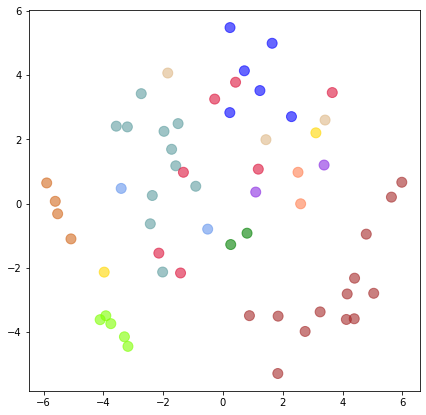

In [59]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)

fig,ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1], c=colors2, s=100, alpha=.6)
